# Explore here

In [9]:
import pandas as pd

df_sales = pd.read_csv ("/Users/luiseduardogarciablanco/Desktop/bootcamp/Serie_Temporal_Alternativa/sales.csv", parse_dates=['date'], index_col='date')

# Asegúrate de que los datos están ordenados por fecha
df_sales = df_sales.sort_index()
df_sales

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


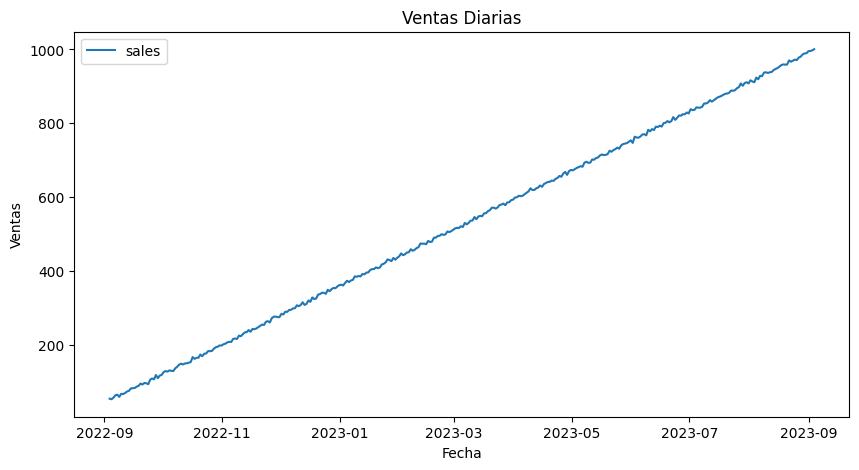

In [8]:
import matplotlib.pyplot as plt

# Visualiza los datos
plt.figure(figsize=(10, 5))
plt.plot(df_sales, label='sales')
plt.title('Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

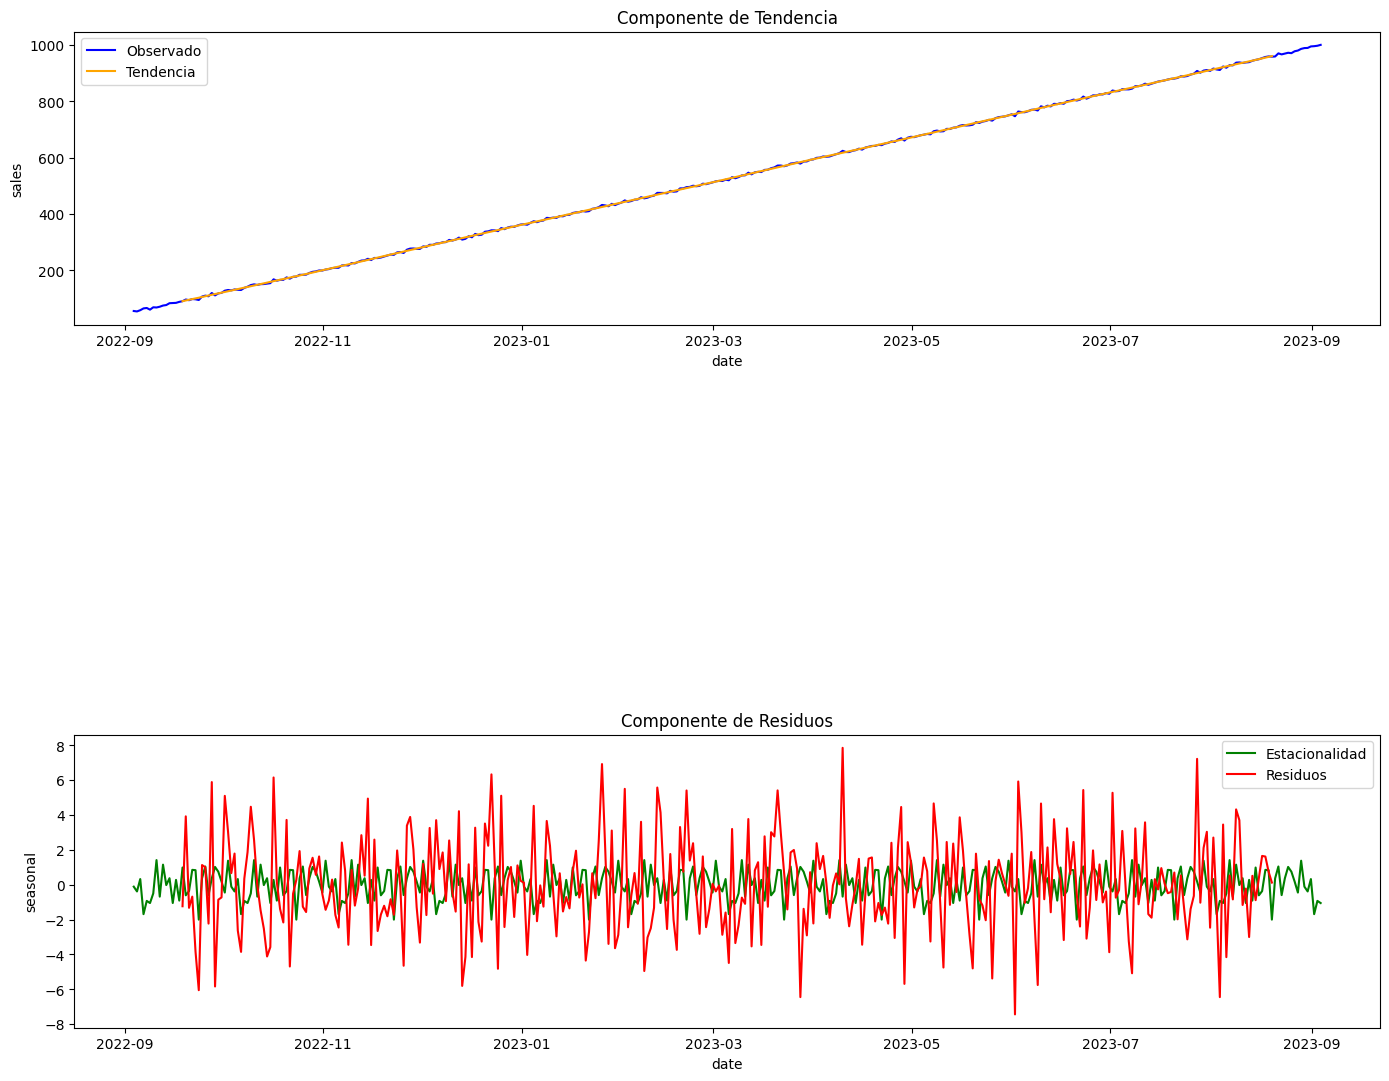

In [15]:
#Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuo

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Descomposición de la serie de tiempo
result = seasonal_decompose(df_sales['sales'], model='additive', period=30)  # Asumiendo una estacionalidad mensual (30 días)

# Extrae los componentes
observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Visualización de los componentes

# Configura el tamaño de las figuras
plt.figure(figsize=(14, 14))

# Observado
plt.subplot(411)
sns.lineplot(data=observed, label='Observado', color='blue')
plt.legend(loc='best')
plt.title('Componente Observado')

# Tendencia
plt.subplot(411)
sns.lineplot(data=trend, label='Tendencia', color='orange')
plt.legend(loc='best')
plt.title('Componente de Tendencia')

# Estacionalidad
plt.subplot(413)
sns.lineplot(data=seasonal, label='Estacionalidad', color='green')
plt.legend(loc='best')
plt.title('Componente Estacional')

# Residuos
plt.subplot(413)
sns.lineplot(data=residual, label='Residuos', color='red')
plt.legend(loc='best')
plt.title('Componente de Residuos')

plt.tight_layout()
plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:

In [18]:
from statsmodels.tsa.stattools import adfuller



# Aplica la prueba de Dickey-Fuller
result_ADF = adfuller(df_sales['sales'])

# Extrae los resultados
adf_statistic = result_ADF[0]
p_value = result_ADF[1]
used_lag = result_ADF[2]
n_obs = result_ADF[3]
critical_values = result_ADF[4]
ic_best = result_ADF[5]

# Muestra los resultados
print(f'Estadístico ADF: {adf_statistic}')
print(f'Valor p: {p_value}')
print(f'Número de retardos utilizados: {used_lag}')
print(f'Número de observaciones utilizadas para la prueba ADF: {n_obs}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')


# Interpreta los resultados
if p_value < 0.05:
    print("La serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("El Valor de 'p', es mayor a 0.5, por eso la serie no es estacionaria (no podemos rechazar la hipótesis nula).")

Estadístico ADF: 0.5454141937063758
Valor p: 0.9861899815311064
Número de retardos utilizados: 13
Número de observaciones utilizadas para la prueba ADF: 352
Valores críticos:
   1%: -3.4490648539347544
   5%: -2.8697861692116478
   10%: -2.5711631253228306
El Valor de 'p', es mayor a 0.5, por eso la serie no es estacionaria (no podemos rechazar la hipótesis nula).


Usaremos las funciones plot_acf y plot_pacf de statsmodels para crear los gráficos de autocorrelación y autocorrelación parcial.

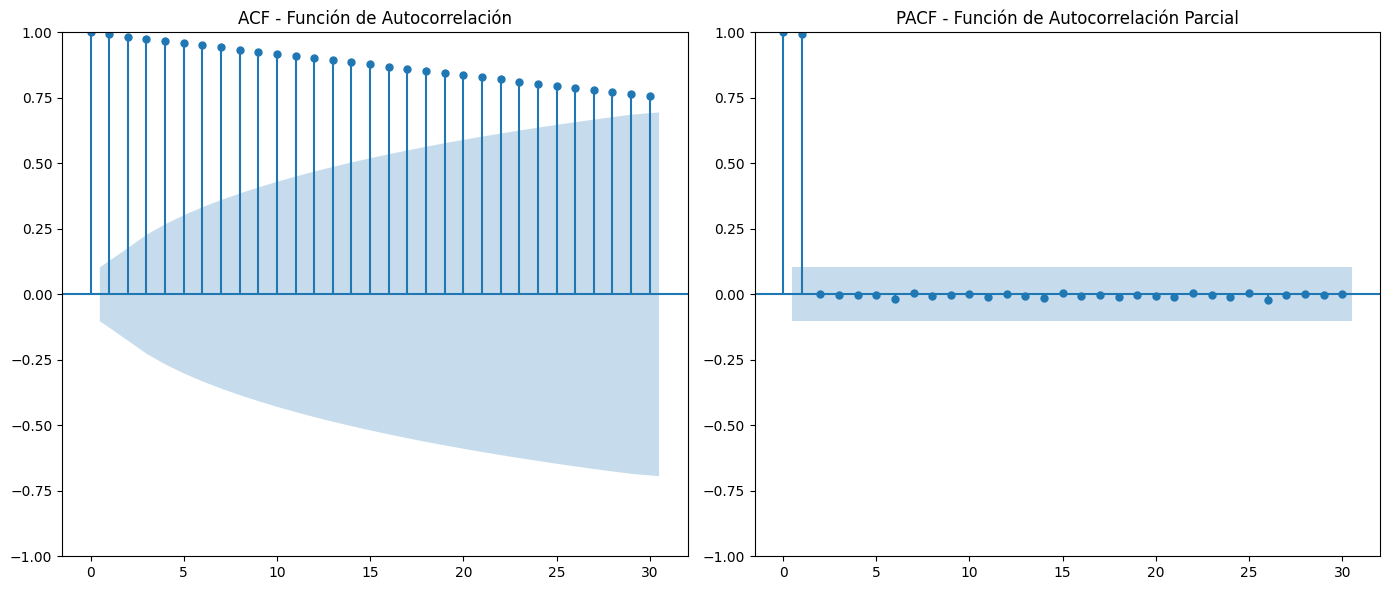

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Análisis de la autocorrelación
plt.figure(figsize=(14, 6))

# Gráfico ACF (Autocorrelation Function)
plt.subplot(121)
plot_acf(df_sales['sales'], lags=30, ax=plt.gca(), title="ACF - Función de Autocorrelación")

# Gráfico PACF (Partial Autocorrelation Function)
plt.subplot(122)
plot_pacf(df_sales['sales'], lags=30, ax=plt.gca(), title="PACF - Función de Autocorrelación Parcial")

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


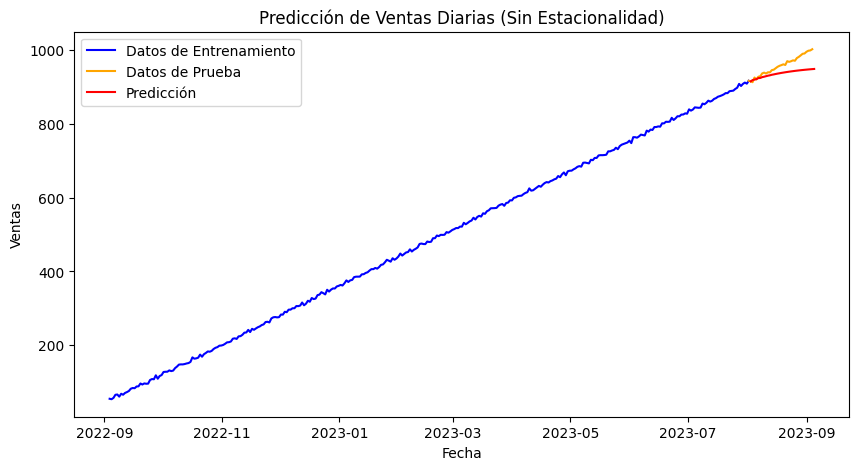

Error Cuadrático Medio: 721.9294771874775


In [21]:
#Entrenamos Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Modelado ARIMA sin estacionalidad si la serie no es estacionaria
if result_ADF[1] >= 0.05:
    deseasonalized_data = df_sales['sales'] - seasonal

    # Divide los datos en entrenamiento y prueba
    train_data = deseasonalized_data[:'2023-08-01']
    test_data = deseasonalized_data['2023-08-01':]

    # Ajusta el modelo ARIMA
    model = ARIMA(train_data, order=(5, 1, 0))
    model_fit = model.fit()

    # Predicción
    forecast = model_fit.forecast(steps=len(test_data))

    # Visualiza la predicción
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=train_data, label='Datos de Entrenamiento', color='blue')
    sns.lineplot(data=test_data, label='Datos de Prueba', color='orange')
    sns.lineplot(data=forecast, label='Predicción', color='red')
    plt.title('Predicción de Ventas Diarias (Sin Estacionalidad)')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend(loc='best')
    plt.show()

    # Calcula el MSE
    mse = mean_squared_error(test_data, forecast)
    print(f'Error Cuadrático Medio: {mse}')

Lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla usando la funcion auto_arima

In [25]:
from pmdarima import auto_arima

# Transformar la serie en estacionaria
ts_stationary = df_sales['sales'].diff().dropna()

# Función para probar la estacionaridad
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'Estadístico ADF: {result[0]}')
    print(f'Valor p: {result[1]}')
    print(f'Número de retardos utilizados: {result[2]}')
    print(f'Número de observaciones utilizadas para la prueba ADF: {result[3]}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("La serie es estacionaria (rechazamos la hipótesis nula).")
    else:
        print("La serie no es estacionaria (no podemos rechazar la hipótesis nula).")

# Probar la estacionaridad de la serie transformada
test_stationarity(ts_stationary)

Estadístico ADF: -9.43026311833476
Valor p: 5.212954111416503e-16
Número de retardos utilizados: 12
Número de observaciones utilizadas para la prueba ADF: 352
Valores críticos:
   1%: -3.4490648539347544
   5%: -2.8697861692116478
   10%: -2.5711631253228306
La serie es estacionaria (rechazamos la hipótesis nula).


ya que la serie la hemos transformado en estacionaria procedemos a ajustar el modelo usando auto_arima

In [30]:


# Ajustar el modelo ARIMA usando auto_arima
model = auto_arima(df_sales['sales'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Resumen del modelo ajustado
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.817 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
M

In [38]:


# Predicción
n_periods = 30  # número de días para predecir
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Crear un rango de fechas para las predicciones
last_date = df_sales.index[-1]
forecast_dates = [last_date + pd.DateOffset(days=i) for i in range(1, n_periods + 1)]

# Crear un DataFrame para las predicciones
predictions = pd.DataFrame(forecast, index=forecast_dates, columns=['Prediction'])
conf_int_df = pd.DataFrame(conf_int, index=forecast_dates, columns=['Lower Bound', 'Upper Bound'])
predictions

,Prediction
2023-09-04 17:10:08.079328,1002.158148
2023-09-05 17:10:08.079328,1004.831668
2023-09-06 17:10:08.079328,1007.423289
2023-09-07 17:10:08.079328,1010.021630
2023-09-08 17:10:08.079328,1012.619419
2023-09-09 17:10:08.079328,1015.217254
2023-09-10 17:10:08.079328,1017.815084
2023-09-11 17:10:08.079328,1020.412915
2023-09-12 17:10:08.079328,1023.010746
2023-09-13 17:10:08.079328,1025.608577


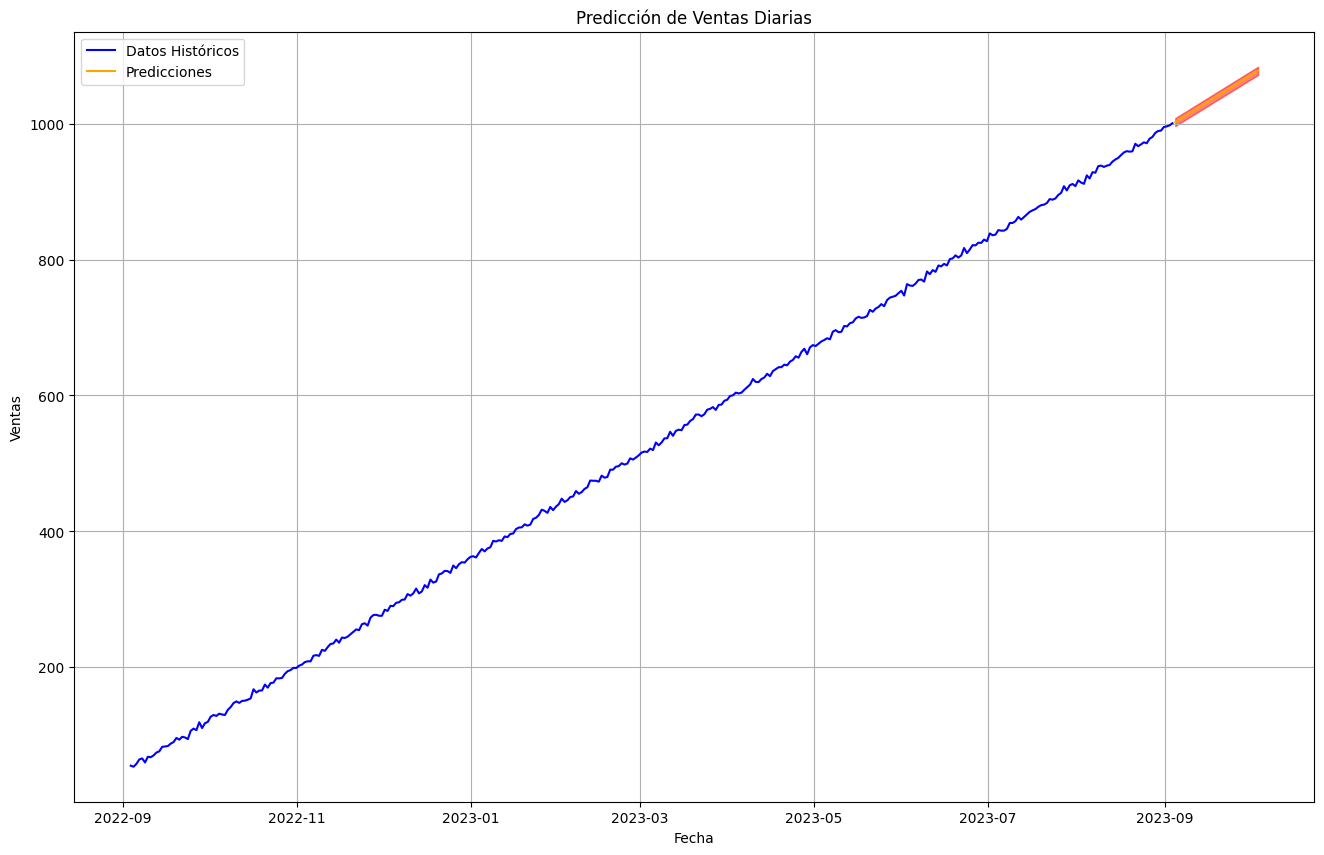

In [46]:

# Visualizar las predicciones junto con los datos históricos
plt.figure(figsize=(16, 10))

# Datos históricos
plt.plot(df_sales.index, df_sales['sales'], label='Datos Históricos', color='blue')

# Predicciones
plt.plot(predictions.index, predictions['Prediction'], label='Predicciones', color='orange')

# Intervalos de confianza
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='red', alpha=0.5)

plt.title('Predicción de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
import joblib

# Guardamos el modelo
joblib.dump(model, 'arima_model.pkl')


['arima_model.pkl']